## Importanto as bibliotecas necessarias:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

/home/felipe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configurando o dataset e os hiperparametros:

In [75]:
batch_size = 128
latent_dim = 20
lr = 0.0002
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda


## Definicao das redes neurais adversarias (GAN):

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

## Instanciando os objetos, otimizadores e funcao de perda:

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

## Treinamento:

[Epoch 10/200] [Avg D loss: 0.29054383661349614] [Avg G loss: 2.6040076665878296]
[Epoch 20/200] [Avg D loss: 0.389702804128329] [Avg G loss: 1.898795697848002]
[Epoch 30/200] [Avg D loss: 0.4582334059874217] [Avg G loss: 1.6292918799718221]
[Epoch 40/200] [Avg D loss: 0.48145222147305805] [Avg G loss: 1.4701360425949097]
[Epoch 50/200] [Avg D loss: 0.5004719138145447] [Avg G loss: 1.4209398460388183]
[Epoch 60/200] [Avg D loss: 0.5159078520933787] [Avg G loss: 1.322986223379771]
[Epoch 70/200] [Avg D loss: 0.5605577657222748] [Avg G loss: 1.1706007571220398]
[Epoch 80/200] [Avg D loss: 0.5876004418532054] [Avg G loss: 1.0848999718030294]
[Epoch 90/200] [Avg D loss: 0.5944855384031932] [Avg G loss: 1.0660020942687989]
[Epoch 100/200] [Avg D loss: 0.5977778489589691] [Avg G loss: 1.0217461732228597]
[Epoch 110/200] [Avg D loss: 0.6100470984776815] [Avg G loss: 0.9891725749969482]
[Epoch 120/200] [Avg D loss: 0.614985059897105] [Avg G loss: 0.975327622572581]
[Epoch 130/200] [Avg D loss:

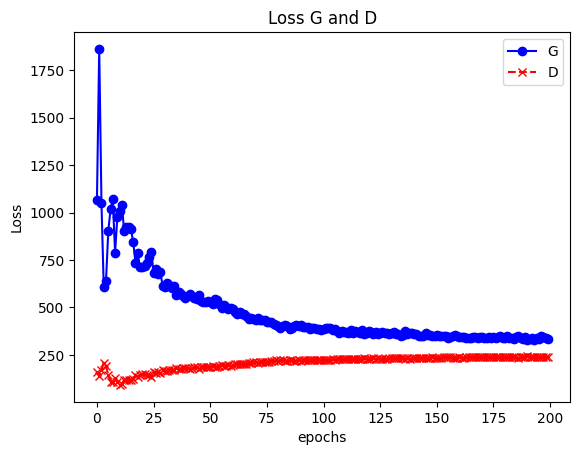

In [14]:
g_loss_per_epoch = []
d_loss_per_epoch = []

for epoch in range(epochs):
    d_loss_accumulated = 0.0
    g_loss_accumulated = 0.0

    for i, (imgs, _) in enumerate(train_loader):
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        pred_real = discriminator(real_imgs)
        loss_real = criterion(pred_real, real)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        pred_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(pred_fake, fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        d_loss_accumulated += d_loss.item()

        optimizer_G.zero_grad()
        pred_fake = discriminator(fake_imgs)
        g_loss = criterion(pred_fake, real)
        g_loss.backward()
        optimizer_G.step()

        g_loss_accumulated += g_loss.item()

        if i == len(train_loader) - 1 and (epoch + 1) % 10 == 0:
            d_loss_avg = d_loss_accumulated / len(train_loader)
            g_loss_avg = g_loss_accumulated / len(train_loader)
            print(f"[Epoch {epoch+1}/{epochs}] [Avg D loss: {d_loss_avg}] [Avg G loss: {g_loss_avg}]")

    torch.save(generator.state_dict(), f'./epochs_gan/g/g_epoch_{epoch + 1}.pth')
    torch.save(discriminator.state_dict(), f'./epochs_gan/d/d_epoch_{epoch + 1}.pth')

    g_loss_per_epoch.append(g_loss_accumulated)
    d_loss_per_epoch.append(d_loss_accumulated)

plt.title('Loss G and D')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(list(range(epochs)), g_loss_per_epoch, label='G', color='b', linestyle='-', marker='o')
plt.plot(list(range(epochs)), d_loss_per_epoch, label='D', color='r', linestyle='--', marker='x')
plt.legend()
plt.show()

## Gerando imagens:

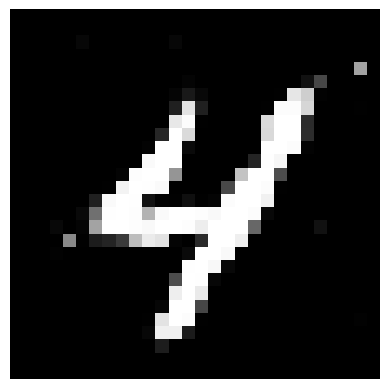

In [158]:
def generate_images(model, device):
    model.eval()
    model.load_state_dict(torch.load(f'./epochs_gan/g/g_epoch_200.pth'))
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        sample = generator(z).cpu()
        sample = sample.view(28, 28)

        return sample

sample = generate_images(generator, device)
plt.imshow(sample, cmap='gray')
plt.axis('off')
plt.show()